In [82]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import glob
import re
import xmltodict
import pickle

from skimage import measure, morphology
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.segmentation import clear_border
from skimage.filters import roberts, sobel

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

DATA_PATH = '/kaggle_2/lidc_idri/data/'
DATA_PATH_XML = '/kaggle_2/lidc_idri/data/tcia-lidc-xml/'
DATA_PATH_SCANS = '/kaggle_2/lidc_idri/data/LIDC/DOI/'
DATA_PATH_POST_PROCESSED_SCANS = '/kaggle_2/lidc_idri/data/scans_resampled_unsegmented/'

In [ ]:
patient_ids = set()
paths = set()
non_ct_files = set()
for filename in glob.glob(DATA_PATH_XML + '**/*.xml', recursive=True):
    with open(filename) as fd:
        doc = xmltodict.parse(fd.read())
        try:
            patient_ids.add(doc['LidcReadMessage']['ResponseHeader']['SeriesInstanceUid'])
            paths.add(doc['LidcReadMessage']['ResponseHeader']['StudyInstanceUID'] + '/' +
                      doc['LidcReadMessage']['ResponseHeader']['SeriesInstanceUid'])
        except KeyError:
            non_ct_files.add(filename)
            continue

In [38]:
patient_scans_map = {}
count = 0
for path in paths:
    [study_id, patient_id] = path.split('/')
    scan_files = glob.glob(DATA_PATH_SCANS + '**/' + path + '/*.dcm', recursive=True)
    xml_files = glob.glob(DATA_PATH_SCANS + '**/' + path + '/*.xml', recursive=True)
    patient_scans_map[patient_id] = {
        'scans': scan_files,
        'xml': xml_files
    }
    count = count + 1
    print(count, patient_id, len(scan_files), len(xml_files))

1 1.3.6.1.4.1.14519.5.2.1.6279.6001.237915456403882324748189195892 122 1
2 1.3.6.1.4.1.14519.5.2.1.6279.6001.199069398344356765037879821616 472 1
3 1.3.6.1.4.1.14519.5.2.1.6279.6001.202283133206014258077705539227 123 1
4 1.3.6.1.4.1.14519.5.2.1.6279.6001.207544473852086582434957174616 101 1
5 1.3.6.1.4.1.14519.5.2.1.6279.6001.121391737347333465796214915391 244 1
6 1.3.6.1.4.1.14519.5.2.1.6279.6001.340012777775661021262977442176 133 1
7 1.3.6.1.4.1.14519.5.2.1.6279.6001.725236073737175770730904408416 216 1
8 1.3.6.1.4.1.14519.5.2.1.6279.6001.297251044869095073091780740645 449 1
9 1.3.6.1.4.1.14519.5.2.1.6279.6001.814122498113547115932318256859 132 1
10 1.3.6.1.4.1.14519.5.2.1.6279.6001.822128649427327893802314908658 131 1
11 1.3.6.1.4.1.14519.5.2.1.6279.6001.994459772950022352718462251777 291 1
12 1.3.6.1.4.1.14519.5.2.1.6279.6001.147250707071097813243473865421 474 1
13 1.3.6.1.4.1.14519.5.2.1.6279.6001.226456162308124493341905600418 241 1
14 1.3.6.1.4.1.14519.5.2.1.6279.6001.1236543563

In [43]:
with open(DATA_PATH + 'patient_scans_map.pkl', 'wb') as f:
    pickle.dump(patient_scans_map, f, pickle.HIGHEST_PROTOCOL)

In [44]:
with open(DATA_PATH + 'patient_scans_map.pkl', 'rb') as f:
    scans_map_copy = pickle.load(f)

In [45]:
len(scans_map_copy)

1018

In [69]:
# Load the scans in given folder path
def load_scan(paths):
    slices = [dicom.read_file(path) for path in paths]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

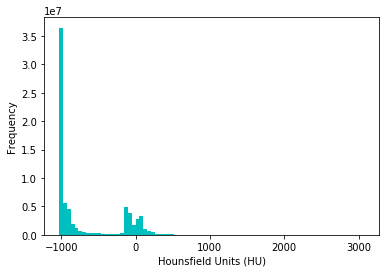

In [70]:
random_patient_id = list(patient_scans_map.keys())[0]
random_patient_scan_files = patient_scans_map[random_patient_id]['scans']
random_patient_scan_files.sort()
random_patient_scan = load_scan(random_patient_scan_files)
random_patient_pixels = get_pixels_hu(random_patient_scan)
plt.hist(random_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

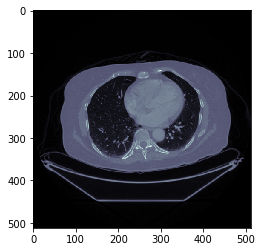

In [76]:
def plot_2d(im):
    # Show some slice in the middle
    plt.imshow(im, cmap=plt.cm.bone)
    plt.show()

# Show some slice in the middle
random_slice_index = int(np.random.random() * len(random_patient_scan))
plot_2d(random_patient_pixels[random_slice_index])

In [77]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    # print(spacing)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    # print(real_resize_factor)
    if (real_resize_factor[0] == 0.0):
        real_resize_factor[0] = 1.0
    image = ndi.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [78]:
pix_resampled, spacing = resample(random_patient_pixels, random_patient_scan, [1,1,1])
print("Shape before resampling\t", random_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (277, 512, 512)
Shape after resampling	 (346, 470, 470)


In [79]:
def plot_3d(image, threshold=-300):
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

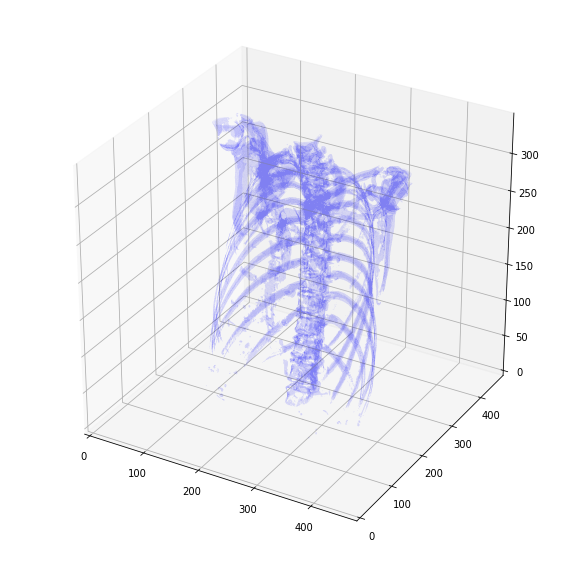

In [80]:
plot_3d(pix_resampled, 400)

In [ ]:
%%time

patients_processed_files = glob.glob(DATA_PATH_POST_PROCESSED_SCANS + 'scan_*.npy')
patients_processed = set()
for filename in patients_processed_files:
    m = re.match(r'scan_([0-9\.]*).npy', os.path.basename(filename))
    patients_processed.add(m.group(1))
    
print('Already processed ' + str(len(patients_processed)) + '/' + str(len(list(patient_scans_map.keys()))) + ' patients')

patient_count = 0
for patient_id in list(patient_scans_map.keys()):
    if patient_id in patients_processed:
        print('Skipping already processed patient ' + patient_id)
        continue
    patient_scan_files = patient_scans_map[patient_id]['scans']
    patient_scan_files.sort()
    patient_scan = load_scan(patient_scan_files)
    patient_pixels = get_pixels_hu(patient_scan)
    pix_resampled, spacing = resample(patient_pixels, patient_scan, [1,1,1])
    np.save(DATA_PATH_POST_PROCESSED_SCANS + "scan_%s.npy" % (patient_id), pix_resampled)
    print('Processed ', patient_count, ' patients')
    patient_count+=1

Already processed 0/1018 patients
